# Group 20: Morawez, Tusha, Chmielowski, Sick 
# Evolution of political parties in European parliaments over time
In this notebook, we explore how representation via political parties has evolved in European parliaments since 1995. We track how politicial parties (summarized in common party families, e.g., liberal, conservative, ecological, etc.) have won or lost vote shares in national elections and how polarization and fragmentation evolved in each country, and look for common patterns across countries. Additionally, we investigate correlations with economic and demographic country characteristics and use them to predict future election outcomes. In detail, we aim at answering the following questions:

- Which trends in election results can we observe per country?
- Which countries show similar types of change in a specific dimension at roughly the same time?
- Which commong patterns can be observed across countries?
- How well can major shifts or trends in parliamentary compositions be explained
by economic and societal conditions?
- To what extend can future parliamentary compositions be predicted by economic
and societal indicators?

In what follows, we present and explain each step of our analysis. We start with a preprocessing section, and then address each of the above research questions in its own section, with an interpretation of the most central result at each section end. At the end of the notebook, we disclose to which extent resources like LLMs were used for this exercise.


# 1. Preprocessing

## 1.1 Package imports and defining path

In [674]:
import numpy as np 
import pandas as pd 
import warnings
import re
import os
from typing import List
from pathlib import Path
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning,
    module=r'pandas\.io\.formats\.format'
)


In [675]:
PATH_ROOT = Path.cwd().parent
PATH_DATA = PATH_ROOT / "data"

In [676]:
eu_country_abbreviations = {
    'Austria': 'AT',
    'Belgium': 'BE',
    'Bulgaria': 'BG',
    'Croatia': 'HR',
    'Cyprus': 'CY',
    'Czechia': 'CZ',
    'Denmark': 'DK',
    'Estonia': 'EE',
    'Finland': 'FI',
    'France': 'FR',
    'Germany': 'DE',
    'Greece': 'GR',
    'Hungary': 'HU',
    'Ireland': 'IE',
    'Italy': 'IT',
    'Latvia': 'LV',
    'Lithuania': 'LT',
    'Luxembourg': 'LU',
    'Malta': 'MT',
    'Netherlands': 'NL',
    'Poland': 'PL',
    'Portugal': 'PT',
    'Romania': 'RO',
    'Slovakia': 'SK',
    'Slovenia': 'SI',
    'Spain': 'ES',
    'Sweden': 'SE'
}

## 1.2 Putting together the dataset
As a first step, we read in the data necessary for our analysis and combine them to a single file. This encompasses data on political parties in Europe over time (party family, vote shares, position on a left-right scale) and economic and demographic country characteristics.
### 1.2.1 Economic and demographic data
The annual **inflation rate** comes from the Harmonized Index of consumer prices (HICP) from Eurostat and depicts year-on-year changes of the average price level, harmonized for all European countries. Inflation is expected to have a strong effect on people's vote choice as price level influences people's lives directly. 


In [677]:
# inflation rate
df_prices = pd.read_csv(PATH_DATA / 'consumer_price_index.csv', low_memory=False)
df_prices = df_prices[(df_prices['coicop'] == 'CP00') & (df_prices['unit'] == 'RCH_A_AVG')] # change in index for all items

PRICES_COLUMNS = ["geo", "TIME_PERIOD", "OBS_VALUE"]
df_prices = df_prices[PRICES_COLUMNS]
df_prices = (
    df_prices
    .rename(columns={"OBS_VALUE": "inflation_rate"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "country"])
    .set_index(["geo", "year"])
)
# df_prices.head


The **unemployment rate** comes also from Eurostat and measures the yearly share of unemployed persons defined under ILO-standards (without work, actively seeking work, available for work) over the total labor force in the country. The unemployment rate might drive people's economic vote choice strongly as it might be correlated with lower bargaining power, higher poverty and higher crime rates.

In [678]:
df_unemployment = pd.read_csv(PATH_DATA / 'unemployment_rate.csv', low_memory=False)
df_unemployment = df_unemployment[df_unemployment['sex'] == 'T']  # or 'total', check first

UNEMPLOYMENT_COLUMNS = ["geo", "TIME_PERIOD", "OBS_VALUE"]
df_unemployment = df_unemployment[UNEMPLOYMENT_COLUMNS]

df_unemployment = (
    df_unemployment
    .rename(columns={"OBS_VALUE": "unemployment_rate"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "country"])
    .set_index(["geo", "year"])
)
df_unemployment.head(10)

unemployment_rate
geo year                   
AT  1995                4.4
    1996                5.3
    1997                5.2
    1998                5.5
    1999                4.7
    2000                4.7
    2001                4.0
    2002                4.9
    2003                4.8
    2004                5.8

**Poverty risk** data comes from Eurostat and is here defined as the percentage of population having an equivalized income of less than 60% of the country's median income after social transfers. Again, this might influence economic voting motives with likely similar effects as unemployment rates (higher crime rates, general economic uncertainty).

In [679]:
df_poverty = pd.read_csv(PATH_DATA / 'poverty_risk.csv', low_memory=False)

df_poverty = (
    df_poverty
    .query("age == 'TOTAL'")  # Filter for total only
    .rename(columns={"OBS_VALUE": "poverty_risk"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year=lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "age"])
)

df_poverty = df_poverty[['geo', 'year', 'poverty_risk']].set_index(["geo", "year"])
df_poverty.head(10)


poverty_risk
geo year              
AL  2017          23.9
    2018          23.8
    2019          23.8
    2020          22.3
    2021          22.5
    2022          21.1
    2023          20.2
AT  1995          15.0
    1996          16.0
    1997          14.0

The **yearly GDP per capita growth** indicator comes from the World Bank database. It might be tied to the general economic outlook in a country, investment and production activity and, in consequence, be people finding employment and future wage raises.

In [680]:
# yearly gdp growth 
df_gdp = pd.read_csv(PATH_DATA / 'gdp_per_cap.csv', 
                     quoting=3, 
                     engine='python', 
                     encoding='utf-8-sig',
                     on_bad_lines='skip')

df_gdp = df_gdp.reset_index()

year_columns = [str(year) for year in range(1995, 2025)]
GDP_COLUMNS = ["index", "Country Code", "Indicator Name"] + year_columns
df_gdp = df_gdp[GDP_COLUMNS]

# Filter for countries from list above
eu_country_names = list(eu_country_abbreviations.keys())
df_gdp = df_gdp[df_gdp["index"].isin(eu_country_names)]

# long format
df_gdp = df_gdp.rename(columns={"index": "country"})
df_gdp = df_gdp.melt(
    id_vars=["country", "Country Code"], 
    value_vars=year_columns,
    var_name="year", 
    value_name="gdp_per_cap"
)

df_gdp = (
    df_gdp
    .rename(columns={"Country Code": "geo_code"})
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year=lambda x: pd.to_numeric(x["year"], errors='coerce').astype("Int64"))
    .assign(gdp_per_cap=lambda x: pd.to_numeric(x["gdp_per_cap"], errors='coerce'))
    .set_index(["geo", "year"])
    .drop(columns=["country", "geo_code"])
)

df_gdp.head(20)

,,gdp_per_cap
geo,year,
AT,1995,2.077849
BE,1995,1.123650
BG,1995,5.749370
CY,1995,-0.352430
CZ,1995,4.289888
DE,1995,0.745819
DK,1995,2.315081
ES,1995,2.180924
EE,1995,6.502782


**Wealth inequality** is measured here as the percentage of total wealth owned by the highest percentile of the wealth distribution. A higher value implies higher wealth inequality. This might impact the working population's perception of fairness and the likeliness of making a good living with one's own work - thus, impacting voting behavior.

In [681]:
# wealth inequality
df_wealth = pd.read_csv(
    PATH_DATA / 'wealth_10p.csv',
    sep=';',
    skiprows=1, 
    on_bad_lines='skip'
) 

new_columns = {}
for col in df_wealth.columns:
    if col in ['Percentile ', 'Year ']:
        new_columns[col] = col.strip()
    else:
        # Extract country name (last part after \n)
        country_name = col.split('\n')[-1]
        new_columns[col] = country_name

df_wealth = df_wealth.rename(columns=new_columns)
df_wealth = df_wealth.drop(columns=['Percentile']) # col not needed
df_wealth = df_wealth.rename(columns={'Year': 'year'})

# Filter countries
eu_country_names = list(eu_country_abbreviations.keys())
available_eu_countries = [col for col in df_wealth.columns if col in eu_country_names]
df_wealth_eu = df_wealth[['year'] + available_eu_countries]

print(f"Found {len(available_eu_countries)} EU countries: {available_eu_countries}")

# Convert to long format
df_wealth_long = df_wealth_eu.melt(
    id_vars=['year'],
    var_name='country',
    value_name='wealth_top10_share'
)

# Convert year to integer and wealth to numeric
df_wealth_long['year'] = pd.to_numeric(df_wealth_long['year'], errors='coerce').astype('Int64')
df_wealth_long['wealth_top10_share'] = pd.to_numeric(df_wealth_long['wealth_top10_share'], errors='coerce')

# Add country code
df_wealth_long['geo'] = df_wealth_long['country'].map(eu_country_abbreviations)

# Set index
df_wealth_long = df_wealth_long.set_index(['geo', 'year']).drop(columns=['country'])

print(f"\nFinal shape: {df_wealth_long.shape}")
df_wealth_long.head()

Found 26 EU countries: ['Slovakia', 'Ireland', 'Lithuania', 'Germany', 'Greece', 'Malta', 'Bulgaria', 'Hungary', 'Italy', 'Austria', 'Spain', 'Croatia', 'Netherlands', 'Romania', 'Luxembourg', 'Slovenia', 'Portugal', 'Sweden', 'France', 'Cyprus', 'Finland', 'Latvia', 'Belgium', 'Denmark', 'Poland', 'Estonia']

Final shape: (780, 1)


wealth_top10_share
geo year                    
SK  1995              0.4174
    1996              0.4174
    1997              0.4175
    1998              0.4178
    1999              0.4181

A country's **debt level** might not impact people's livelihoods directly but the projection of how sustainable the overall welfare system is. It is measured as debt divided by GDP and comes from the IMF's Global Debt Database.

In [682]:
# debt to gdp ratio
df_debt = pd.read_csv(
    PATH_DATA / 'imf_debtToGdp.csv', 
    sep=';',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

df_debt = df_debt.rename(columns={'General Government Debt (Percent of GDP)': 'country'})

# Filter for EU countries
eu_country_names = list(eu_country_abbreviations.keys())
df_debt = df_debt[df_debt['country'].isin(eu_country_names)]

# Select only years 1995-2024
year_columns = [str(year) for year in range(1995, 2025)]
df_debt = df_debt[['country'] + year_columns]

# Convert to long format
df_debt_long = df_debt.melt(
    id_vars=['country'],
    var_name='year',
    value_name='debt_to_gdp'
)

# Convert year to integer
df_debt_long['year'] = pd.to_numeric(df_debt_long['year'], errors='coerce').astype('Int64')

# Handle the number format: keep only first decimal point, remove the rest
# 68.238.169 -> 68.238169 -> 68.2 (round to 1 decimal)
df_debt_long['debt_to_gdp'] = df_debt_long['debt_to_gdp'].replace('no data', None)
df_debt_long['debt_to_gdp'] = df_debt_long['debt_to_gdp'].astype(str).str.replace('.', '', regex=False).str[:3]  # Keep first 3 chars
df_debt_long['debt_to_gdp'] = df_debt_long['debt_to_gdp'].apply(lambda x: f"{x[:-1]}.{x[-1]}" if len(x) >= 2 and x != 'Non' else None)
df_debt_long['debt_to_gdp'] = pd.to_numeric(df_debt_long['debt_to_gdp'], errors='coerce')

# Add country code
df_debt_long['geo'] = df_debt_long['country'].map(eu_country_abbreviations)

# Set index
df_debt_long = df_debt_long.set_index(['geo', 'year']).drop(columns=['country'])

print(f"\nFinal shape: {df_debt_long.shape}")
df_debt_long.head(20)


Final shape: (750, 1)


,,debt_to_gdp
geo,year,
AT,1995,68.2
BE,1995,13.1
BG,1995,NaN
HR,1995,NaN
CY,1995,45.8
DK,1995,71.4
EE,1995,86.5
FI,1995,55.2
FR,1995,57.8


**Immigration** is an important driver of vote choice, especially for parties with anti-immigration platforms. Data on total immigration inflow comes from Eurostat, and divided by total population (also from Eurostat) to get a relative measure of immigration.

In [683]:
# immigration total
df_immigration = pd.read_csv(
    PATH_DATA / 'immigration_total.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

IMMIGRATION_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_immigration = df_immigration[IMMIGRATION_COLUMNS]
df_immigration = (
    df_immigration
    .rename(columns={"OBS_VALUE": "migration_inflow"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_immigration.head(20)


migration_inflow
geo year                  
AT  1996             69930
    1997             70122
    1998             72723
    1999             86710
    2000             81676
    2001             89928
    2002            108125
    2003            111869
    2004            122547
    2005            114465
    2006             98535
    2007             72862
    2008             73772
    2009             69295
    2010             70978
    2011             82230
    2012             91557
    2013            101866
    2014            116262
    2015            166323

**Total population**, as mentioned, also comes from Eurostat and is used to calculate an indicator of relative immigration inflow.

In [684]:
# population total
df_population = pd.read_csv(
    PATH_DATA / 'population_total.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

POPULATION_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_population = df_population[POPULATION_COLUMNS]
df_population = (
    df_population
    .rename(columns={"OBS_VALUE": "population_total"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_population.head(100)


population_total
geo     year                  
Andorra 1995             64085
        1996             64169
        1997             64893
        1998             65592
        1999             65924
...                        ...
AT      2014           8546356
        2015           8642699
        2016           8736668
        2017           8797566
        2018           8840521

[100 rows x 1 columns]

The **dependency ratio** is another important indicator for the sustainability of a country's welfare system. It comes from Eurostat and is defined as people under 15 plus over 64 years old (non-working age) divided by the population 15 to 64 years old (working age). A higher dependency ratio therefore means that, per person of working age, there are more people dependent on the social system in some way (schooling, family benefits, pensioneers). Like other measures related to system stability (debt ratio, GDP growth), this might influence peoples voting.

In [685]:
# dependency ratio
df_age_ratio = pd.read_csv(
    PATH_DATA / 'age_ratio.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

AGE_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_age_ratio = df_age_ratio[AGE_COLUMNS]
df_age_ratio = (
    df_age_ratio
    .rename(columns={"OBS_VALUE": "dependency_ratio_15_64"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_age_ratio.head(100)


dependency_ratio_15_64
geo        year                        
Andorra    1995                    35.1
           1996                    36.0
           1997                    36.4
           1998                    36.7
           1999                    36.9
...                                 ...
Azerbaijan 2016                    40.2
           2017                    40.8
           2018                    41.1
           2019                    41.3
           2020                    42.0

[100 rows x 1 columns]

The **median age** in a country is an important variable on population structure. It also comes from Eurostat.

In [686]:
# median age 
df_median_age = pd.read_csv(
    PATH_DATA / 'median_age.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

AGE_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_median_age = df_median_age[AGE_COLUMNS]
df_median_age = (
    df_median_age
    .rename(columns={"OBS_VALUE": "median_age"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_median_age.head(100)


median_age
geo        year            
Andorra    1995        34.1
           1996        34.6
           1997        35.0
           1998        35.5
           1999        35.9
...                     ...
Azerbaijan 2016        30.9
           2017        31.3
           2018        31.8
           2019        32.3
           2020        32.8

[100 rows x 1 columns]

A country population's **educational attainment** levels are also important predictors: Low general levels might lead to stronger support more populist parties. Here, educational attainment is measured by the population percentage of people with tertiary education according to ISCED 2011 (university level). The complement to 100% is, consequently, the share of the population with lower educational attainment. The data comes from Eurostat.

In [687]:
# educational attainment
df_education = pd.read_csv(
    PATH_DATA / 'educational_attainment.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

df_education = (
    df_education
    .query("`International Standard Classification of Education (ISCED 2011)` == 'Tertiary education (levels 5-8)'")
    .rename(columns={
        "OBS_VALUE": "Tertiary education",
        "Geopolitical entity (reporting)": "country"
    })
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year=lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    [['geo', 'year', 'Tertiary education']]
    .set_index(['geo', 'year'])
)

df_education.head(10)


Tertiary education
geo year                    
AT  1995                 6.7
    1996                 6.9
    1997                 7.0
    1998                 7.0
    1999                12.3
    2000                 NaN
    2001                 NaN
    2002                 NaN
    2003                 NaN
    2004                15.4

The share of population living in **urban conditions** might influence how voters thing about agricultural and environmental issues. The data comes from the World Bank database.

In [688]:
# urban population
df_urban = pd.read_csv(
    PATH_DATA / 'urban_population.csv', 
    sep=',',
    encoding='utf-8-sig',
    skiprows=4,
    quoting=3,
    engine='python',
    on_bad_lines='skip'
)

# clean up some stuff
df_urban = df_urban.reset_index()
df_urban.columns = df_urban.columns.str.replace('"', '', regex=False)
df_urban = df_urban.apply(lambda x: x.str.replace('"', '', regex=False) if x.dtype == 'object' else x)
df_urban = df_urban.rename(columns={'index': 'country'})

# Filter for countries and years
eu_country_names = list(eu_country_abbreviations.keys())
df_urban = df_urban[df_urban['country'].isin(eu_country_names)]
year_columns = [str(year) for year in range(1995, 2025)]
df_urban = df_urban[['country'] + year_columns]

# Convert to long
df_urban_long = df_urban.melt(
    id_vars=['country'],
    var_name='year',
    value_name='urban_population_pct'
)
df_urban_long['year'] = pd.to_numeric(df_urban_long['year'], errors='coerce').astype('Int64')
df_urban_long['urban_population_pct'] = pd.to_numeric(df_urban_long['urban_population_pct'], errors='coerce')


df_urban_long['geo'] = df_urban_long['country'].map(eu_country_abbreviations)
df_urban_long = df_urban_long.set_index(['geo', 'year']).drop(columns=['country'])

print(f"Final shape: {df_urban_long.shape}")
df_urban_long.head(20)

Final shape: (780, 1)


,,urban_population_pct
geo,year,
AT,1995,66.110930
BE,1995,80.684478
BG,1995,67.698196
CY,1995,68.334940
CZ,1995,74.556649
DE,1995,80.054357
DK,1995,85.039203
ES,1995,75.697224
EE,1995,68.447574


## 1.2.2 Manifesto project
The **Manifesto project** is a joint effort by Political Scientists of the Berlin Social Science Center to extract quantitative data on political parties (e.g., factual position on a left-right scale, their substantive positions of various topics) from party manifesto texts in all European and many other countries. Included are parties that ran for national elections and gathered at least one seat in parliament (with some exceptions, see [here](https://manifestoproject.wzb.eu/questions)). The dataset also includes the vote shares for each party at each election, and categorizes parties into larger "party families". For this project, we make use of these data to measure vote shares by party (and later aggregated to party family vote shares), left-right positioning of parties (to measure overall polarization in the country) and number of parties (to measure party fragmentation). 

In the cell below, these data are loaded, columns and party family codes are renamed and relevant countries are selected.

In [689]:
# read data
manifesto = pd.read_csv(
    PATH_DATA / 'manifesto.csv', 
    sep=',',
    encoding='utf-8-sig',
    engine='python',
    on_bad_lines='skip'
)

# select columns
MANIFESTO_COLUMNS = ['countryname', 
                     'edate', 
                     'partyname', 
                     'pervote', 
                     'party', 
                     'parfam', 
                     'rile', 
                     'planeco', 
                     'welfare', 
                     'markeco', 
                     'per107', 
                     'per202', 
                     'per416_2']

manifesto = manifesto[MANIFESTO_COLUMNS]

# renaming columns
renaming_map = {
    'partyname': 'party_name',
    'pervote': 'vote_share_percent',
    'countryname': 'country',
    'edate': 'election_date',
    'party': 'party_code',
    'rile': 'right_left_position',
    'planeco': 'planned_economy',
    'welfare': 'welfare_state',
    'markeco': 'market_economy',
    'per107': 'inter_positive',
    'per202': 'democracy',    
    'per416_2': 'sustainability_positive',  
}

# renaming party families
PARFAM = {
    10:  {"abbreviations": "ECO", "label": "Ecological parties"},
    20:  {"abbreviations": "LEF", "label": "Socialist or other left parties"},
    30:  {"abbreviations": "SOC", "label": "Social democratic parties"},
    40:  {"abbreviations": "LIB", "label": "Liberal parties"},
    50:  {"abbreviations": "CHR", "label": "Christian democratic parties (in Israel also Jewish parties)"},
    60:  {"abbreviations": "CON", "label": "Conservative parties"},
    70:  {"abbreviations": "NAT", "label": "Nationalist and radical right parties"},
    80:  {"abbreviations": "AGR", "label": "Agrarian parties"},
    90:  {"abbreviations": "ETH", "label": "Ethnic and regional parties"},
    95:  {"abbreviations": "SIP", "label": "Special issue parties"},
    98:  {"abbreviations": "DIV", "label": "Electoral alliances of diverse origin without dominant party"},
    999: {"abbreviations": "MI",  "label": "Missing information"},
}
manifesto =manifesto.rename(columns=renaming_map)

manifesto["election_date"] = pd.to_datetime(
    manifesto["election_date"], 
    format='%d/%m/%Y', 
    errors='coerce' 
)           
manifesto["parfam_code"] = manifesto["parfam"].map({k: v["abbreviations"] for k, v in PARFAM.items()})
manifesto["parfam_label"] = manifesto["parfam"].map({k: v["label"] for k, v in PARFAM.items()})

# chose European countries
eu_countries = [
    'Austria',
    'Belgium',
    'Bulgaria',
    'Croatia',
    'Cyprus',
    'Czechia',
    'Denmark',
    'Estonia',
    'Finland',
    'France',
    'Germany',
    'Greece',
    'Hungary',
    'Ireland',
    'Italy',
    'Latvia',
    'Lithuania',
    'Luxembourg',
    'Malta',
    'Netherlands',
    'Poland',
    'Portugal',
    'Romania',
    'Slovakia',
    'Slovenia',
    'Spain',
    'Sweden'
]
manifesto = manifesto.loc[manifesto["country"].isin(eu_countries)].copy()
manifesto["geo"] = manifesto["country"].map(eu_country_abbreviations)
manifesto["election_date"] = pd.to_datetime(manifesto["election_date"])
manifesto["year"] = manifesto["election_date"].dt.year
manifesto.head(10)


,country,election_date,party_name,vote_share_percent,party_code,parfam,right_left_position,planned_economy,welfare_state,market_economy,inter_positive,democracy,sustainability_positive,parfam_code,parfam_label,geo,year
0,Sweden,1944-09-17,Communist Party of Sweden,10.300,11220,20,9.60,1.9,0.0,1.900,0.0,0.0,NaN,LEF,Socialist or other left parties,SE,1944
1,Sweden,1944-09-17,Social Democratic Labour Party,46.500,11320,30,-37.80,3.3,33.4,2.200,4.4,1.1,NaN,SOC,Social democratic parties,SE,1944
2,Sweden,1944-09-17,People’s Party,12.900,11420,40,9.50,3.2,14.3,6.400,3.2,6.4,NaN,LIB,Liberal parties,SE,1944
3,Sweden,1944-09-17,Right Party,15.800,11620,60,28.00,1.8,10.6,22.800,3.5,0.0,NaN,CON,Conservative parties,SE,1944
4,Sweden,1944-09-17,Agrarian Party,13.600,11810,80,23.81,0.0,0.0,19.048,0.0,0.0,NaN,AGR,Agrarian parties,SE,1944
5,Sweden,1948-09-19,Communist Party of Sweden,6.312,11220,20,-44.00,8.0,18.0,2.000,0.0,10.0,NaN,LEF,Socialist or other left parties,SE,1948
6,Sweden,1948-09-19,Social Democratic Labour Party,46.132,11320,30,-33.40,6.7,20.8,5.800,1.7,5.0,NaN,SOC,Social democratic parties,SE,1948
7,Sweden,1948-09-19,People’s Party,22.749,11420,40,22.90,2.3,7.0,13.700,1.2,3.4,NaN,LIB,Liberal parties,SE,1948
8,Sweden,1948-09-19,Right Party,12.343,11620,60,56.30,0.0,0.0,50.000,0.0,3.1,NaN,CON,Conservative parties,SE,1948
9,Sweden,1948-09-19,Agrarian Party,12.385,11810,80,-4.90,3.5,13.5,9.200,0.0,2.1,NaN,AGR,Agrarian parties,SE,1948


In order to meaningfully merge the data from the Manifesto dataset (one row for every country-election date-party combination) with the data on economic and demographic characteristics (with rows for every country and every year), we need to inflate the Manifesto dataset to have rows for every year, too. This is done in the follwing cell by defining *between-election segments* and copying the content of the corresponding country-election date-party combination into these segments. The election date marks the beginning of each segment (e.g, the Ausrian National Election of 1995 for the segment 1995 - 1999), through which party positions and vote share of the most last election are perceived as the most recent values for this period. For each country-election date-party combination, values from the last election before 2024 are "filled up" to 2024. 

At the end of the following cell, the relevant time frame used in this project is selected (1995-2024). This is from when the most economic and demographic data is available for every country.

In [690]:
manifesto = manifesto.sort_values(['geo', 'election_date'])
END_YEAR = 2024

# get all election years per country
election_years_by_country = manifesto.groupby('geo')['year'].apply(lambda x: sorted(x.unique())).to_dict()

def fill_years(group, geo, party_code):
    group = group.copy()
    group['year'] = group['year'].astype(int)
    group = group.drop_duplicates(subset=['year'])
    
    country_elections = election_years_by_country[geo]
    party_election_years = sorted(group['year'].tolist())
    
    # build segments: only fill between consecutive elections where party ran
    segments = []
    for i, start_year in enumerate(party_election_years):
        next_country_elections = [y for y in country_elections if y > start_year]
        
        if i + 1 < len(party_election_years):
            next_party_election = party_election_years[i + 1]
            elections_between = [y for y in next_country_elections if y < next_party_election]
            if elections_between:
                end_year = elections_between[0]
            else:
                end_year = next_party_election
        else:
            if next_country_elections:
                end_year = next_country_elections[0]
            else:
                end_year = END_YEAR + 1
        
        segments.append((start_year, end_year))
    
    # build the filled dataframe from segments
    filled_dfs = []
    for start_year, end_year in segments:
        segment_data = group[group['year'] == start_year].copy()
        full_years = pd.RangeIndex(start_year, end_year, name='year')
        segment_data = segment_data.set_index('year').reindex(full_years)
        segment_data['geo'] = geo
        segment_data['party_code'] = party_code
        segment_data = segment_data.ffill()
        filled_dfs.append(segment_data.reset_index())
    
    return pd.concat(filled_dfs, ignore_index=True)

# Apply
manifesto = manifesto.dropna(subset=['vote_share_percent']) # remove parties with NAN vote share (the changed name or ran in coalitions, might be double-counted otherwise)
manifesto_filled = (
    manifesto
    .groupby(['geo', 'party_code'], group_keys=False)
    .apply(lambda g: fill_years(g, g.name[0], g.name[1]), include_groups=False)
)
manifesto_filled = manifesto_filled.sort_values(['geo', 'year', 'party_name']).reset_index(drop=True)

# filter relevant year range
manifesto_filled = manifesto_filled.query('1995 <= year <= 2024')


## 1.2.3 Merging datasets
In the cell below, all datasets (Manifesto data, economic and demographic data) are merged to one.

In [691]:
right_dfs = [df_poverty, 
             df_gdp, 
             df_prices, 
             df_unemployment, 
             df_age_ratio,
             df_debt_long,
             df_education,
             df_immigration,
             df_median_age,
             df_population,
             df_urban_long,
             df_wealth_long]

manifesto_final = manifesto_filled.set_index(["geo", "year"])
df = manifesto_final

# Perform sequential left merges
for right_df in right_dfs:
    # Remove duplicates from right dataframe before merging
    right_df_clean = right_df[~right_df.index.duplicated(keep='first')]
    
    df = pd.merge(
        left=df,
        right=right_df_clean,
        how='left',
        left_index=True, 
        right_index=True,                  
        suffixes=('', '_new_data')        
    )
df = df.sort_index(level=['geo', 'year'])

# calculate the relative migration indicator (total immigration divided by total population)
df["rel_immigration"] = 100*df["migration_inflow"]/df["population_total"]
df = df.drop(columns = ["population_total", "migration_inflow"])

df.head()

country election_date                        party_name  \
geo year                                                            
AT  1995  Austria    1995-12-17           Austrian People’s Party   
    1995  Austria    1995-12-17  Austrian Social Democratic Party   
    1995  Austria    1995-12-17                  Freedom Movement   
    1995  Austria    1995-12-17                     Liberal Forum   
    1995  Austria    1995-12-17                        The Greens   

          vote_share_percent  parfam  right_left_position  planned_economy  \
geo year                                                                     
AT  1995              28.291    50.0               40.417            1.250   
    1995              38.059    30.0               20.849            0.386   
    1995              21.885    70.0               55.705            0.000   
    1995               5.513    40.0               64.706            2.941   
    1995               4.815    10.0               19.658            0.855   

          welfare_state  market_economy  inter_positive  ...  gdp_per_cap  \
geo year                                                 ...                
AT  1995          7.083          26.250           1.250  ...     2.077849   
    1995         21.622           3.861           4.247  ...     2.077849   
    1995          7.383          12.752           0.000  ...     2.077849   
    1995         14.706          26.471           0.000  ...     2.077849   
    1995         14.530           4.274           0.855  ...     2.077849   

          inflation_rate unemployment_rate dependency_ratio_15_64  \
geo year                                                            
AT  1995             NaN               4.4                   49.0   
    1995             NaN               4.4                   49.0   
    1995             NaN               4.4                   49.0   
    1995             NaN               4.4                   49.0   
    1995             NaN               4.4                   49.0   

          debt_to_gdp  Tertiary education  median_age  urban_population_pct  \
geo year                                                                      
AT  1995         68.2                 6.7        36.1              66.11093   
    1995         68.2                 6.7        36.1              66.11093   
    1995         68.2                 6.7        36.1              66.11093   
    1995         68.2                 6.7        36.1              66.11093   
    1995         68.2                 6.7        36.1              66.11093   

          wealth_top10_share  rel_immigration  
geo year                                       
AT  1995              0.6066              NaN  
    1995              0.6066              NaN  
    1995              0.6066              NaN  
    1995              0.6066              NaN  
    1995              0.6066              NaN  

[5 rows x 26 columns]

In some rare cases, a country had two elections in the same year. This creates problems when trying to add upp vote shares accross parties for one year, because it leads to double counting. As a major focus of this project is to investigate how important economic and demographic factors contribute to a party family's *subsequent* success in elections in Europe (both in a descriptive analysis and in prediction), we decided to only keep the first election in these cases. Second elections in the same year are typically a sign of coalition infighting and scandals and might not reflect the effect of said economic and demgraphic factors. 

In addition, for one specific case, party code 34212 had to be removed manually from the dataset from 2012 onwards (SYRIZA in Greece), as this party joined a coalition in that year and was assigned a different party_code from the second election onwards. This is not picked up by drop_duplicates because of different party codes, which might lead to double counting.

In [692]:
# Deduplicate and remove SYRIZA
df = df.reset_index().sort_values('election_date').drop_duplicates(
    subset=['geo', 'year', 'party_code'], keep='first'
).set_index(['geo', 'year'])

df = df.reset_index()
df = df[~((df['geo'] == 'GR') & 
          (df['year'] >= 2012) & 
          (df['party_code'] == 34020))]
df = df.set_index(['geo', 'year'])

The following cell extracts the vote shares for every election by party family. That is, for every national election in every country, votes for partys belonging to the same party family are added up and provided in wide format. Also, a fragmentation index (how fragmented is the party landscape) and a polarization index (based on the left-right indicator from Manifesto) is calculated.

In [693]:
"""

def election_df(df):
        
    d = df.reset_index()[["geo","election_date","party_code","parfam_code","vote_share_percent","right_left_position"]].copy()

    # one row per party per election
    d = (d.dropna(subset=["geo","election_date","party_code","vote_share_percent"])
           .groupby(["geo","election_date","party_code"], as_index=False)
           .agg(voteshare=("vote_share_percent","first"), parfam=("parfam_code","first"), lr_score=("right_left_position","first")))

    d["vote share proportion"] = d["voteshare"] / 100.0

    # vote shares by party family
    fam = (d.groupby(["geo","election_date","parfam"])["voteshare"]
             .sum()
             .unstack(fill_value=0)
             .add_prefix("vs_"))

    # fragmentation ENP
    enp = d.groupby(["geo","election_date"])["vote share proportion"].apply(lambda s: 1 / (s**2).sum()).rename("fragmentation_enp")

    # Dalton polarization
    def dalton(g):
        g = g.dropna(subset=["vote share proportion","lr_score"])
        w, lr_score = g["vote share proportion"].to_numpy(), g["lr_score"].to_numpy()
        return np.nan if len(w) == 0 else float(np.sqrt((w * ((lr_score - (w*lr_score).sum()/w.sum()) / 5)**2).sum()))
    
    pol = (d.groupby(["geo", "election_date"])[["vote share proportion", "lr_score"]].apply(dalton).rename("polarization_dalton"))
    out = pd.concat([fam, enp, pol], axis=1).reset_index()
    out["election_year"] = out["election_date"].dt.year
    out = out.set_index(["geo", "election_year"]).sort_index()
    return out

elections = election_df(df)

# deduplicate
elections = elections.reset_index().sort_values('election_date').drop_duplicates(
    subset=['geo', 'election_year'], keep='first'
).set_index(['geo', 'election_year']).sort_index()

elections.head()
"""

'\n\ndef election_df(df):\n        \n    d = df.reset_index()[["geo","election_date","party_code","parfam_code","vote_share_percent","right_left_position"]].copy()\n\n    # one row per party per election\n    d = (d.dropna(subset=["geo","election_date","party_code","vote_share_percent"])\n           .groupby(["geo","election_date","party_code"], as_index=False)\n           .agg(voteshare=("vote_share_percent","first"), parfam=("parfam_code","first"), lr_score=("right_left_position","first")))\n\n    d["vote share proportion"] = d["voteshare"] / 100.0\n\n    # vote shares by party family\n    fam = (d.groupby(["geo","election_date","parfam"])["voteshare"]\n             .sum()\n             .unstack(fill_value=0)\n             .add_prefix("vs_"))\n\n    # fragmentation ENP\n    enp = d.groupby(["geo","election_date"])["vote share proportion"].apply(lambda s: 1 / (s**2).sum()).rename("fragmentation_enp")\n\n    # Dalton polarization\n    def dalton(g):\n        g = g.dropna(subset=["vote 

## 1.3 Dealing with missings
First, we create an overview of prevalence and distribution of missings.

In [694]:
# count and percentage of missings per column
missing_summary = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_pct': (df.isna().sum() / len(df) * 100).round(2)
}).sort_values('missing_pct', ascending=False)

missing_summary[missing_summary['missing_count'] > 0]

,missing_count,missing_pct
sustainability_positive,3493,62.15
poverty_risk,1002,17.83
rel_immigration,543,9.66
gdp_per_cap,431,7.67
urban_population_pct,431,7.67
inflation_rate,419,7.46
unemployment_rate,404,7.19
Tertiary education,275,4.89
debt_to_gdp,254,4.52
dependency_ratio_15_64,37,0.66


Note that missings in Manifesto data (planned economy, sustainability) are permissible because this simply means that this party did not talk these topics in their manifestos. They can be left as is. More attention needs to be put on economic and demographic data. Below, we see how prevalent these missings are in each country.

In [695]:
# Columns to check (only those with missings)
socioeco_vars = ['poverty_risk', 
                 'rel_immigration',
                 'gdp_per_cap',
                 'urban_population_pct',
                 'inflation_rate',
                 'unemployment_rate',
                 'Tertiary education',
                 'debt_to_gdp',
                 'dependency_ratio_15_64',
                 'median_age']

missing_by_country = (df.reset_index()
    .groupby('geo')[socioeco_vars]
    .apply(lambda x: x.isna().mean() * 100)
    .round(1)
)
missing_by_country = missing_by_country.T
missing_by_country = missing_by_country.loc[:, (missing_by_country > 0).any()]
missing_by_country

geo,AT,BE,BG,CY,DE,DK,EE,ES,FI,FR,...,LU,LV,MT,NL,PL,PT,RO,SE,SI,SK
poverty_risk,3.2,3.0,24.1,23.2,8.8,13.9,22.5,3.0,6.8,2.6,...,3.0,32.5,25.4,5.2,29.2,3.1,31.8,15.6,21.2,30.5
rel_immigration,6.3,10.3,54.2,10.2,4.1,3.7,22.0,3.8,3.6,34.2,...,3.6,3.9,31.7,4.9,3.1,5.2,48.1,3.6,3.7,4.0
gdp_per_cap,3.2,3.6,3.0,4.5,4.1,3.7,2.7,3.8,3.6,3.8,...,3.6,3.9,3.2,4.9,3.1,5.2,3.9,3.6,3.7,100.0
urban_population_pct,3.2,3.6,3.0,4.5,4.1,3.7,2.7,3.8,3.6,3.8,...,3.6,3.9,3.2,4.9,3.1,5.2,3.9,3.6,3.7,100.0
inflation_rate,3.2,3.0,9.0,2.8,2.9,3.4,3.8,3.0,3.6,2.6,...,3.0,8.9,3.2,7.0,7.3,2.1,5.2,3.1,3.3,3.1
unemployment_rate,0.0,0.0,15.1,11.3,0.0,0.0,7.7,0.0,0.0,0.0,...,0.0,13.3,12.7,0.0,7.3,0.0,9.1,0.0,3.3,9.3
Tertiary education,11.4,0.0,15.1,8.5,2.9,0.0,11.5,0.0,0.0,0.0,...,3.0,13.3,12.7,3.5,7.3,0.0,9.1,0.0,3.3,9.3
debt_to_gdp,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
dependency_ratio_15_64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_age,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It appears that especially poverty risk and immigration has many missings, and that especially Greece and Slovakia has poor data coverage for economic and demographic data. Next, we look if these variables are missing completely at random (MCAR), at random (MAR) or not at random (MNAR). The test below measures of missingness of variables is related to other variables (MAR).

In [696]:
# MAR test
def test_mar_all(df, test_cols):
    from scipy import stats
    
    results = []
    for test_col in test_cols:
        missing_mask = df[test_col].isna()
        
        # skip if no missings
        if missing_mask.sum() == 0:
            continue
            
        for compare_col in test_cols:
            if compare_col == test_col:
                continue
                
            group_missing = df.loc[missing_mask, compare_col].dropna()
            group_observed = df.loc[~missing_mask, compare_col].dropna()
            
            if len(group_missing) > 5 and len(group_observed) > 5:
                stat, pval = stats.ttest_ind(group_missing, group_observed)
                results.append({
                    'missing_var': test_col,
                    'compared_var': compare_col,
                    'mean_when_missing': round(group_missing.mean(), 2),
                    'mean_when_observed': round(group_observed.mean(), 2),
                    'mean_diff': round(group_observed.mean() - group_missing.mean(), 2),
                    'p_value': round(pval, 4),
                    'significant': pval < 0.05
                })
    
    return pd.DataFrame(results).sort_values('p_value')

# Run for all variables
mar_results = test_mar_all(df.reset_index(), socioeco_vars)

# Show only significant results
mar_results[mar_results['significant']]

,missing_var,compared_var,mean_when_missing,mean_when_observed,mean_diff,p_value,significant
0,poverty_risk,rel_immigration,0.54,1.05,0.51,0.0000,True
38,inflation_rate,unemployment_rate,10.37,8.42,-1.95,0.0000,True
40,inflation_rate,debt_to_gdp,36.62,45.79,9.18,0.0000,True
42,inflation_rate,median_age,38.83,40.44,1.61,0.0000,True
43,unemployment_rate,rel_immigration,0.62,0.99,0.37,0.0000,True
...,...,...,...,...,...,...,...
34,inflation_rate,poverty_risk,15.83,16.72,0.89,0.0332,True
64,debt_to_gdp,inflation_rate,4.35,3.35,-1.00,0.0345,True
17,rel_immigration,median_age,40.05,40.35,0.30,0.0361,True
29,urban_population_pct,unemployment_rate,8.86,8.43,-0.43,0.0456,True


It seems that most missings are MAR, i.e., dependent on other variables. It is therefore possible to deal with missing values with interpolation and imputation. For this, we choose a two step approach: First, interpolation and extrapolation where possible, then imputation of remaining gaps using other variables. Poverty risk is dropped completely from the data as 17% is missing (see above), imputation is therefore likely not reliable.

In [697]:
df = df.drop(columns='poverty_risk')
socioeco_vars = [var for var in socioeco_vars if var != 'poverty_risk']

# save for later comparison
missing_mask_original = df[socioeco_vars].isna().copy()

# Get one row per country-year for socioeco vars
country_year = df.reset_index().drop_duplicates(['geo', 'year'])[['geo', 'year'] + socioeco_vars].copy()
country_year = country_year.sort_values(['geo', 'year']).set_index(['geo', 'year'])

# Interpolate (inside gaps up to 5 values)
country_year[socioeco_vars] = country_year.groupby('geo')[socioeco_vars].transform(
    lambda x: x.interpolate(method='linear', limit_area='inside', limit=5))

# extrapolate (outside up to 3 values)
country_year[socioeco_vars] = country_year.groupby('geo')[socioeco_vars].transform(
    lambda x: x.interpolate(method='linear', limit_area='outside', limit=3, limit_direction='both'))

# Check remaining missings
print("missings after interpolation/extrapolation:")
print(country_year[socioeco_vars].isna().sum())

# Impute remainder gaps
if country_year[socioeco_vars].isna().any().any():
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    imputer = IterativeImputer(random_state=42, max_iter=10)
    country_year[socioeco_vars] = imputer.fit_transform(country_year[socioeco_vars])

# Merge back
df = df.drop(columns=socioeco_vars)
df = df.merge(country_year, left_index=True, right_index=True)

# Save missing mask at country-year level for visualization
missing_mask = missing_mask_original.reset_index().drop_duplicates(['geo', 'year']).set_index(['geo', 'year'])

missings after interpolation/extrapolation:
rel_immigration           35
gdp_per_cap               30
urban_population_pct      30
inflation_rate            31
unemployment_rate         38
Tertiary education         7
debt_to_gdp               30
dependency_ratio_15_64     3
median_age                 3
dtype: int64


Quick check if it worked:

In [698]:
# number of missings
print("Missings after imputation")
print(df[socioeco_vars].isna().sum())

Missings after imputation
rel_immigration           0
gdp_per_cap               0
urban_population_pct      0
inflation_rate            0
unemployment_rate         0
Tertiary education        0
debt_to_gdp               0
dependency_ratio_15_64    0
median_age                0
dtype: int64


In [699]:
from ipywidgets import interact, Dropdown

def plot_with_imputation_markers(var, geo):
    data = country_year.loc[geo, var].sort_index()
    was_missing = missing_mask.loc[geo, var].sort_index()
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.plot(data.index, data.values, 'b-', marker='o', label='Data')
    imputed_idx = was_missing[was_missing].index
    if len(imputed_idx) > 0:
        ax.scatter(imputed_idx, data.loc[imputed_idx], color='red', s=100, zorder=5, label='Imputed')
    
    ax.set_xlabel('Year')
    ax.set_ylabel(var)
    ax.set_title(f'{var} in {geo} (red = imputed)')
    ax.legend()
    plt.tight_layout()
    plt.show()

countries = sorted(country_year.reset_index()['geo'].unique())

interact(
    plot_with_imputation_markers,
    var=Dropdown(options=socioeco_vars, value=socioeco_vars[0], description='Variable:'),
    geo=Dropdown(options=countries, value='DE', description='Country:'))

interactive(children=(Dropdown(description='Variable:', options=('rel_immigration', 'gdp_per_cap', 'urban_popu…

<function __main__.plot_with_imputation_markers(var, geo)>

# Research Question 1: 
## How have parliamentary compositions in European countries evolved over time and what major shifts or trends can be observed?

Outline: 

1. Data Preparation for Trend Analysis

2. Trend Analysis

3. Results

## Data preparation for Trend Analysis: Analysis Dataframe

For our analysis, we transform the Manifesto election data into an election dataframe, that for each country x election stores:

1. Party-family vote shares

2. Fragmentation index (Operationalization: Laakso et al., see [Effective number of parties, Quadratic](https://en.wikipedia.org/wiki/Effective_number_of_parties) (ENP)) using normalized vote shares
	
3. Polarization index (Operationalization: Dalton, see [Polarization Index](https://felixgruenewald.gitlab.io/encyclopediaofpolarization/measures/polarization-index/)) from party left–right positions weighted by normalized vote shares

This dataframe enables our Trend Analysis per country (RQ 1), which we will later use to analyze cross country trends (RQ 2).

Note: The Dalton polarization index normalizes ideological dispersion by half of the theoretical left–right scale range. While the original formulation assumes a 0–10 left–right scale (implying a denominator of 5), our left–right positions from the Manifesto Project (RILE) are theoretically bounded in [−100, +100]. We therefore normalize the polarization index by the corresponding half-range (100).

In [700]:
def election_df(df):
    """
    for each country x election, computes:
        vote shares by party family, 
        the fragmentation index (effective number of parties (ENP))
        and Dalton polarization index.
    """
        
    election_data = df.reset_index()[["geo","election_date","party_code","parfam_code","vote_share_percent","right_left_position"]].copy()

    # one row per party per election
    election_data = (election_data.dropna(subset=["geo","election_date","party_code","vote_share_percent"]).groupby(["geo","election_date","party_code"], as_index=False).agg(voteshare=("vote_share_percent","first"), parfam=("parfam_code","first"), lr_scores=("right_left_position","first")))

    # normalize voteshares for fragmentation / polarization computation
    election_data["vote_share_proportion"] = election_data["voteshare"] / 100.0
    total = election_data.groupby(["geo","election_date"])["vote_share_proportion"].transform("sum")
    election_data["vote_share_normalized"] = np.where(total > 0, election_data["vote_share_proportion"] / total, np.nan)

    # vote shares by party family
    fam = (election_data.groupby(["geo","election_date","parfam"])["voteshare"].sum().unstack(fill_value=0).add_prefix("vs_"))

    # fragmentation index (ENP)
    enp = election_data.groupby(["geo","election_date"])["vote_share_normalized"].apply(lambda s: 1 / (s**2).sum()).rename("fragmentation_enp")

    def dalton(election_parties):
        """
        Polarization index (Dalton)
        """
        election_parties = election_parties.dropna(subset=["vote_share_normalized", "lr_scores"])

        # Left–right (RILE) scale from Manifesto Project
        LR_LOWER = -100.0
        LR_UPPER = 100.0
        # denominator normalizes by half of the theoretical scale range
        LR_DENOMINATOR = (LR_UPPER - LR_LOWER) / 2 # 100

        vote_weights = election_parties["vote_share_normalized"].to_numpy()
        lr_scores = election_parties["lr_scores"].to_numpy()

        if len(vote_weights) == 0:
            return np.nan

        weighted_mean_lr = (vote_weights * lr_scores).sum() / vote_weights.sum()
        polarization = np.sqrt((vote_weights * ((lr_scores - weighted_mean_lr) / LR_DENOMINATOR) ** 2).sum()) # range: [0, 0.3]

        return float(polarization)
    
    # compute polarization index per country x election
    pol = (election_data.groupby(["geo", "election_date"])[["vote_share_normalized", "lr_scores"]].apply(dalton).rename("polarization_dalton"))

    # combine results into one election x country level dataframe
    out = pd.concat([fam, enp, pol], axis=1).reset_index()
    out["election_year"] = out["election_date"].dt.year
    out = out.set_index(["geo", "election_year"]).sort_index()
    return out

elections = election_df(df)

# deduplicate
elections = elections.reset_index().sort_values('election_date').drop_duplicates(subset=['geo', 'election_year'], keep='first').set_index(['geo', 'election_year']).sort_index()

elections.head()

election_date  vs_AGR  vs_CHR  vs_CON  vs_DIV  vs_ECO  \
geo election_year                                                         
AT  1995             1995-12-17     0.0  28.291     0.0     0.0   4.815   
    1999             1999-10-03     0.0  26.910     0.0     0.0   7.400   
    2002             2002-11-24     0.0  42.300     0.0     0.0   9.470   
    2006             2006-10-01     0.0  34.330     0.0     0.0  11.050   
    2008             2008-09-28     0.0  25.980     0.0     0.0  10.430   

                   vs_ETH  vs_LEF  vs_LIB  vs_NAT  vs_SIP  vs_SOC  \
geo election_year                                                   
AT  1995              0.0   0.000   5.513  21.885     0.0  38.059   
    1999              0.0   0.000   0.000  26.910     0.0  33.200   
    2002              0.0   0.562   0.000  10.010     0.0  36.510   
    2006              0.0   0.000   0.000  15.150     0.0  35.340   
    2008              0.0   0.760   0.000  28.240     0.0  29.260   

                   fragmentation_enp  polarization_dalton  
geo election_year                                          
AT  1995                    3.492726             0.154671  
    1999                    3.421928             0.160389  
    2002                    2.949982             0.026347  
    2006                    3.418859             0.066626  
    2008                    4.345174             0.072297

## Data preparation for Trend Analysis: Inter-election change distributions and epsilon calibration

Later, trend episodes will be classified as up, down or flat based on inter-election changes. To classify flat changes, we compute an **epsilon** (small change tolerance) per variable type:

1. Vote shares (vs_*) in percentage points

2. Fragmentation (fragmentation_enp) in ENP units

3. Polarization (polarization_dalton) in Dalton units

For each country, we compute absolute inter-election changes, pool them across countries, take the median of absolute change, then define:

- epsilon = 0.2 x median of change (vs, fragmentation or polarization)

Note: For most elections, many party-families are not present and thus voteshares are zero. Therefore, zeros are excluded from median computation.


Median change and epsilons:
Vote shares (vs_*): median change = 3.907 => epsilon_vs = 0.781
Fragmentation (ENP): median change = 0.470 => epsilon_enp = 0.094
Polarization (Dalton): median change = 0.042 => epsilon_pol = 0.008


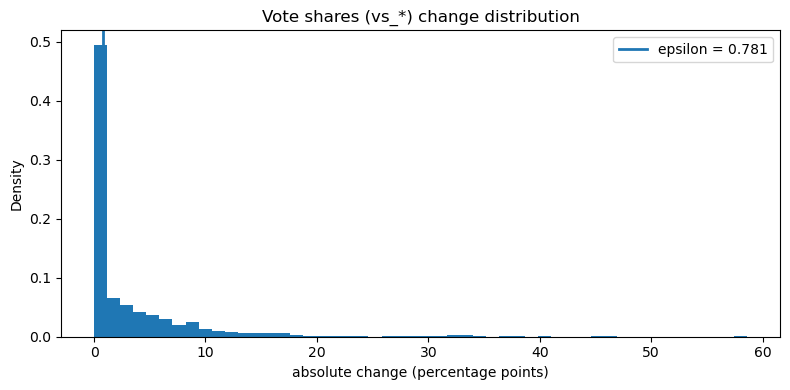

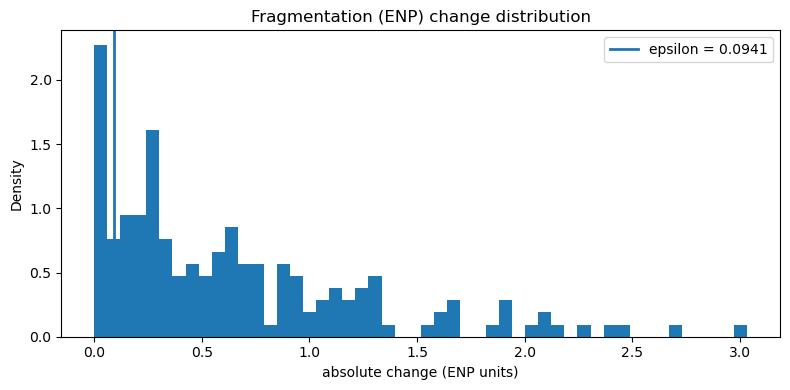

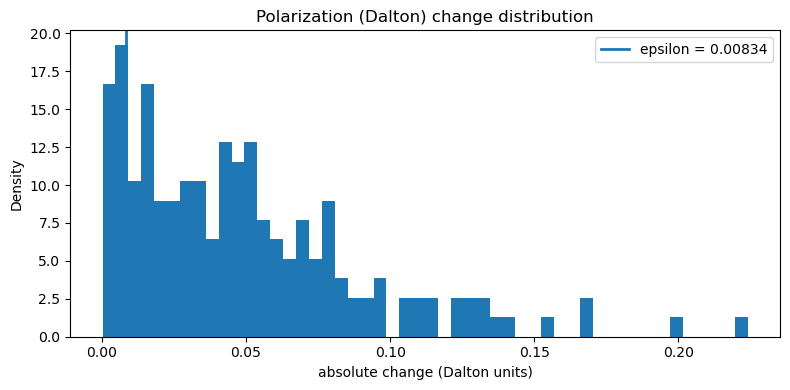

In [701]:
def absolute_step_changes(df_country_year: pd.DataFrame) -> pd.Series:
    """
    for one country:
        compute pooled absolute election-election changes
    """
    step_deltas = df_country_year.sort_index().diff()  
    return step_deltas.abs().stack().dropna()

# voteshare columns
vs_cols = [c for c in elections.columns if c.startswith("vs_")]
if len(vs_cols) == 0:
    raise ValueError("No vote share columns found")

# compute change distributions per variable type
vs_deltas = []
enp_deltas = []
pol_deltas = []

for geo, country_ts in elections.groupby(level=0):
    country_ts = country_ts.droplevel(0) # election year index

    vs_deltas.append(absolute_step_changes(country_ts[vs_cols]))
    enp_deltas.append(absolute_step_changes(country_ts[["fragmentation_enp"]]))
    pol_deltas.append(absolute_step_changes(country_ts[["polarization_dalton"]]))

vs_deltas = pd.concat(vs_deltas, ignore_index=True)
enp_deltas = pd.concat(enp_deltas, ignore_index=True)
pol_deltas = pd.concat(pol_deltas, ignore_index=True)

# median changes, but ignore zero voteshare (e.g. party family not present) changes
vs_deltas_nonzero = vs_deltas[vs_deltas > 0]
med_vs = float(vs_deltas_nonzero.median())
med_enp = float(enp_deltas.median())
med_pol = float(pol_deltas.median())

# compute epsilon (small change tolerance: "noise") per variable type
epsilon_multiplier = 0.2
epsilon_vs = med_vs * epsilon_multiplier
epsilon_enp = med_enp * epsilon_multiplier
epsilon_pol = med_pol * epsilon_multiplier

print("\nMedian change and epsilons:")
print(f"Vote shares (vs_*): median change = {med_vs:.3f} => epsilon_vs = {epsilon_vs:.3f}")
print(f"Fragmentation (ENP): median change = {med_enp:.3f} => epsilon_enp = {epsilon_enp:.3f}")
print(f"Polarization (Dalton): median change = {med_pol:.3f} => epsilon_pol = {epsilon_pol:.3f}")

# diagnostic plots: distributions of change with epsilon marker
def plot_abs_delta_hist(abs_deltas: pd.Series, eps: float, title: str, xlabel: str, bins: int = 50):
    plt.figure(figsize=(8, 4))
    plt.hist(abs_deltas, bins=bins, density=True)
    plt.axvline(eps, linewidth=2, label=f"epsilon = {eps:.3g}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_abs_delta_hist(vs_deltas, epsilon_vs, "Vote shares (vs_*) change distribution", "absolute change (percentage points)")
plot_abs_delta_hist(enp_deltas, epsilon_enp, "Fragmentation (ENP) change distribution", "absolute change (ENP units)")
plot_abs_delta_hist(pol_deltas, epsilon_pol, "Polarization (Dalton) change distribution", "absolute change (Dalton units)")

# Analysis: Trend episode detection for all countries

For each country and each variable (party-family vote shares, fragmentation and polarization), we search the election time series for trend episodes from 1995. 

- Trend episode = a maximal time window of continuous inter-election steps that move in the same direction (up or down) for at least two transitions (3 elections), ignoring small changes (within variable specific epsilons) treated as "noise" (flat).

In [702]:
def detect_all_trends(elections: pd.DataFrame, epsilon_vs: float, epsilon_enp: float, epsilon_pol: float, start_year: int = 1995, min_transitions: int = 2):
    """
    for each country x elections:
        determines all trends, max of consecutive same direction changes, starting from start_year with a minimum of 2 transitions (3 elections).
    """

    # var list
    vs_cols = [c for c in elections.columns if c.startswith("vs_")]
    variables = vs_cols + ["fragmentation_enp", "polarization_dalton"]

    # epsilon look-up
    eps = {c: epsilon_vs for c in vs_cols} | {
        "fragmentation_enp": epsilon_enp,
        "polarization_dalton": epsilon_pol,
    }

    def episodes(years, values, epsilon):
        """
        Detect trend episodes in a single time series
        """
        # classify election-election change
        step_deltas = np.diff(values) 
        step_labels = np.full(step_deltas.shape, "flat", dtype=object)
        step_labels[step_deltas >  epsilon] = "up"
        step_labels[step_deltas < -epsilon] = "down" 

        # find all trend episodes
        found, n_steps, i = [], len(step_deltas), 0
        while i < n_steps:

            # skip flat changes
            if step_labels[i] == "flat":
                i += 1
                continue

            # continuous same direction windows
            direction = step_labels[i] # up or down
            j = i
            while j + 1 < n_steps and step_labels[j + 1] == direction:
                j += 1

            # minimum transitions filter
            if (j - i + 1) >= min_transitions:

                # trend episode values
                episode_values = values[i : j + 2]
                episode_steps = step_deltas[i : j + 1]
                total_change = float(episode_values[-1] - episode_values[0])
                
                # (store) trend episode stats
                found.append({
                        "start_year": int(years[i]),
                        "end_year": int(years[j + 1]),
                        "start_value": float(episode_values[0]),
                        "end_value": float(episode_values[-1]),
                        "n_elections": int(j - i + 2),
                        "direction": direction,
                        "mean_slope": float(total_change / (len(episode_values) - 1)),
                        "peak_slope": float(episode_steps[np.argmax(np.abs(episode_steps))]),
                        "total_change": total_change,
                    })

            # continue search
            i = j + 1

        return found

    # for all countries x variables
    rows = []
    for geo, country_ts in elections.groupby(level=0):

        # election year index (country-level), filter years
        country_ts = country_ts.droplevel(0).sort_index()
        country_ts = country_ts[country_ts.index >= start_year]

        # per var
        for v in variables:
            ts = country_ts[v].dropna()
            if len(ts) < (min_transitions + 1):  # transitions = elections-1
                continue

            yrs = ts.index.to_numpy()
            values = ts.to_numpy(dtype=float)

            # find trend episodes 
            for ep in episodes(yrs, values, eps[v]):
                rows.append({
                "geo": geo,
                "variable": v,
                 "var_type": "vs" if v.startswith("vs_") else ("enp" if v == "fragmentation_enp" else "pol"),
                 **ep
                })

    return (pd.DataFrame(rows).sort_values(["variable", "geo", "start_year"]).reset_index(drop=True))

episodes = detect_all_trends(elections, epsilon_vs=epsilon_vs, epsilon_enp=epsilon_enp, epsilon_pol=epsilon_pol, start_year=1995, min_transitions=2)
episodes.head()

,geo,variable,var_type,start_year,end_year,start_value,end_value,n_elections,direction,mean_slope,peak_slope,total_change
0,AT,fragmentation_enp,enp,2002,2013,2.949982,4.626779,4,up,0.558932,0.926316,1.676797
1,BE,fragmentation_enp,enp,2007,2014,9.129832,8.093669,3,down,-0.518082,-0.785239,-1.036163
2,BG,fragmentation_enp,enp,1997,2005,2.560044,4.849606,3,up,1.144781,1.932163,2.289563
3,BG,fragmentation_enp,enp,2005,2013,4.849606,3.149927,3,down,-0.849840,-1.078158,-1.699680
4,DE,fragmentation_enp,enp,2002,2009,3.022575,4.126196,3,up,0.551811,0.640779,1.103621


# Trend analysis: Country-level visualization and overview of trends

For visual inspection, we build an interactive view to inspect each country’s election series:

1. Stacked area chart of party-family vote shares.

2. Fragmentation (ENP) and Polarization (Dalton), with colorized trends and flat steps.

For each country, we provide an overview with the largest episodes (ranked by absolute total change).

In [703]:
# party family color palette
FAMILY_COLORS = {
    "vs_SOC": "#e41a1c",   # Social democratic parties
    "vs_LEF": "#7f0000",   # Socialist or other left parties
    "vs_ECO": "#4daf4a",   # Ecological parties
    "vs_LIB": "#ffb000",   # Liberal parties
    "vs_CHR": "#000000",   # Christian democratic parties
    "vs_CON": "#377eb8",   # Conservative parties
    "vs_NAT": "#6a3c03",   # Nationalist and radical right parties
    "vs_AGR": "#b68528",   # Agrarian parties
    "vs_ETH": "#1fbfcf",   # Ethnic and regional parties
    "vs_SIP": "#984ea3",   # Special issue parties
    "vs_DIV": "#bdbdbd"    # Electoral alliances
}

# direction colors
DIR_COLOR = {"up": "green", "down": "red", "flat": "gray"}

def shade_episodes(ax, episodes_df, alpha=0.22):
    """
    shades trend episodes in graphics
    """
    for _, r in episodes_df.iterrows():
        ax.axvspan(r.start_year, r.end_year, alpha=alpha, color=DIR_COLOR.get(r.direction, "gray"))

def top_episodes(episodes_df, k):
    """
    return top trend episodes table
    """
    if episodes_df.empty:
        return episodes_df
    return (episodes_df.assign(impact=episodes_df["total_change"].abs()).sort_values("impact", ascending=False).head(k)[["variable","direction","start_year","end_year","mean_slope","peak_slope","total_change"]])

def shade_flat_steps(ax, series: pd.Series, eps: float, alpha=0.10):
    """
    shades flat steps in graphics
    """
    series = series.dropna().sort_index()
    yrs = series.index.to_numpy()
    values = series.to_numpy(dtype=float)
    if len(values) < 2:
        return
    step_deltas = np.diff(values)
    for k in range(len(step_deltas)):
        if abs(step_deltas[k]) <= eps:
            ax.axvspan(int(yrs[k]), int(yrs[k+1]), alpha=alpha, color="gray")

def plot_country(geo, elections, episodes, epsilon_enp, epsilon_pol, start_year=1995, top_vs=10, top_enp=3, top_pol=3):
    """
    for each country:
        plot stacked area chart of vote shares over time and a time series of fragmentation and polarization
    """
    fam = [c for c in elections.columns if c.startswith("vs_")]
    cols = fam + ["fragmentation_enp", "polarization_dalton"]

    # filter 
    country_ts = elections.loc[geo, cols].copy()
    country_ts = country_ts[country_ts.index >= start_year].sort_index()
    country_episodes = episodes[(episodes.geo == geo) & (episodes.start_year >= start_year)].copy()

    vs_episodes  = country_episodes[country_episodes["variable"].str.startswith("vs_")]
    enp_episodes = country_episodes[country_episodes["variable"].eq("fragmentation_enp")]
    pol_episodes = country_episodes[country_episodes["variable"].eq("polarization_dalton")]

    # plot stacked area vote shares
    fig, ax = plt.subplots(figsize=(11, 5))
    country_ts[fam].plot.area(
        stacked=True, alpha=0.9, ax=ax,
        color=[FAMILY_COLORS[c] for c in fam],
        title=f"{geo}: Vote shares by party family"
    )
    ax.set_xlabel("Election year"); ax.set_ylabel("Vote share (%)")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Party family")
    plt.tight_layout()
    plt.show()

    # show top vote share episodes
    tab_vs = top_episodes(vs_episodes, top_vs).copy()
    if not tab_vs.empty:
        tab_vs["variable"] = tab_vs["variable"].str.replace("^vs_", "", regex=True)
    print(f"{geo} — Top vote-share episodes")
    display(tab_vs)

    # plot fragmentation index
    fig, ax = plt.subplots(figsize=(11, 3))
    country_ts["fragmentation_enp"].plot(ax=ax, title=f"{geo}: Fragmentation (ENP)")
    shade_episodes(ax, enp_episodes)
    shade_flat_steps(ax, country_ts["fragmentation_enp"], epsilon_enp)
    ax.set_xlabel("Election year"); ax.set_ylabel("ENP")
    plt.tight_layout()
    plt.show()

    print(f"{geo} — Top ENP episodes")
    display(top_episodes(enp_episodes, top_enp))

    # plot polarization index
    fig, ax = plt.subplots(figsize=(11, 3))
    country_ts["polarization_dalton"].plot(ax=ax, title=f"{geo}: Polarization (Dalton)")
    shade_flat_steps(ax, country_ts["polarization_dalton"], epsilon_pol)  
    shade_episodes(ax, pol_episodes)
    ax.set_xlabel("Election year"); ax.set_ylabel("Polarization")
    plt.tight_layout()
    plt.show()

    print(f"{geo} — Top polarization episodes")
    display(top_episodes(pol_episodes, top_pol))


# Interactive UI widget

import ipywidgets as w

# country view options (one, multiple, all)
all_geos = sorted(elections.index.get_level_values(0).unique())
mode = w.ToggleButtons(options=["Selected", "All"], value="Selected", description="Mode")
geo_sel = w.SelectMultiple(options=all_geos, value=(all_geos[0],), description="Countries", rows=10)

# slider
top_vs_w  = w.IntSlider(value=8, min=1, max=20, step=1, description="Top vs_*")
top_enp_w = w.IntSlider(value=3, min=1, max=10, step=1, description="Top ENP")
top_pol_w = w.IntSlider(value=3, min=1, max=10, step=1, description="Top Pol")

out = w.Output()

# run widget
def _run(*_):
    with out:
        clear_output(wait=True)
        geos = all_geos if mode.value == "All" else list(geo_sel.value)
        for geo in geos:
            plot_country(
                geo, elections=elections, episodes=episodes,
                epsilon_enp=epsilon_enp, epsilon_pol=epsilon_pol,
                top_vs=top_vs_w.value, top_enp=top_enp_w.value, top_pol=top_pol_w.value
            )

# event detection
for widget in [mode, geo_sel, top_vs_w, top_enp_w, top_pol_w]:
    widget.observe(_run, names="value")

# display and run
display(w.HBox([w.VBox([mode, geo_sel]), w.VBox([top_vs_w, top_enp_w, top_pol_w])]))
display(out)
_run()

Output()

# Trend analysis results

For RQ1 insights, we summarize all trend episodes by variable (party-family voteshares, fragmentation and polarization) and direction to extract patterns. Further, we visually inspect all time-series visualizations to evaluate and confirm patterns. Slow long-term shifts as well as short-term shifts are not captured by our consecutive directional (major) shift detection.

In [709]:
eps = episodes.copy()

eps["duration_years"] = eps["end_year"] - eps["start_year"]
eps["abs_total_change"] = eps["total_change"].abs()

# summary
rq1_var_dir_summary = (
    eps.groupby(["variable", "var_type", "direction"], as_index=False)
       .agg(
           n_episodes=("geo", "count"),
           n_countries=("geo", "nunique"),
           median_duration_years=("duration_years", "median"),
           median_abs_change=("abs_total_change", "median"),
       ).sort_values(["n_countries", "median_abs_change"], ascending=False))

display("RQ1: Episode patterns by variable x direction", rq1_var_dir_summary)

'RQ1: Episode patterns by variable x direction'

,variable,var_type,direction,n_episodes,n_countries,median_duration_years,median_abs_change
23,vs_SOC,vs,down,22,19,8.0,11.386377
20,vs_NAT,vs,up,18,17,8.0,17.623000
3,polarization_dalton,pol,up,16,15,8.0,0.087581
16,vs_LEF,vs,up,13,13,8.0,8.622000
1,fragmentation_enp,enp,up,15,13,9.0,1.676797
18,vs_LIB,vs,up,11,11,8.0,17.979000
6,vs_CHR,vs,down,12,11,8.0,16.319889
19,vs_NAT,vs,down,11,11,7.0,12.677000
17,vs_LIB,vs,down,11,11,9.0,12.266810
0,fragmentation_enp,enp,down,11,11,8.0,1.543987


We compute the vote-share weighted left–right positions for each party family and summarize them using mean and median.

In [705]:
lr_df = df.reset_index()[[
    "geo",
    "election_date",
    "parfam_code",
    "vote_share_percent",
    "right_left_position"
]].dropna(subset=["parfam_code", "vote_share_percent", "right_left_position"])

# compute voteshare weights
lr_df["weight"] = lr_df["vote_share_percent"] / 100

# weighted mean left–right score per country x election x party family
lr_family = (lr_df.assign(weighted_lr=lambda d: d["right_left_position"] * d["weight"]).groupby(["geo", "election_date", "parfam_code"], as_index=False).agg(
    lr_weighted_mean=("weighted_lr", "sum"),
    weight_sum=("weight", "sum")))

lr_family["lr_weighted_mean"] = lr_family["lr_weighted_mean"] / lr_family["weight_sum"]
lr_family = lr_family.drop(columns="weight_sum")

# summary across countries and elections
lr_family_summary = (lr_family.groupby("parfam_code").agg(
        lr_mean=("lr_weighted_mean", "mean"),
        lr_median=("lr_weighted_mean", "median"),
        n_parties=("lr_weighted_mean", "count")
    ).sort_values("lr_mean"))

display(lr_family_summary)

,lr_mean,lr_median,n_parties
parfam_code,,,
LEF,-23.496841,-26.646843,118
ECO,-16.266328,-15.828000,86
SOC,-12.855927,-13.480000,189
DIV,-12.569429,-13.239000,7
SIP,-6.609324,-5.018000,44
ETH,-5.406263,-4.297328,68
AGR,0.244533,-2.240000,49
LIB,3.012018,0.566765,135
CHR,3.874008,3.142555,123


## Result summary:

1. Parliamentary composition in Europe evolved dynamically (1995 - 2025):

    Across most party families as well as for fragmentation and polarization, a large number of trend episodes are detected. More than ten trend episodes (up or down) are identified for most party families, with social democratic parties (SOC) exhibiting the highest number of trend episodes. Fragmentation and polarization each show 26 trend episodes, highlighting frequent directional changes in parliamentary composition.

    Trend episodes have a median duration of approximately eight years, which is driven by our trend episode definition and the limited observation window of three decades.

2. Vote share dynamics across party families

- 2.1 Long-term decline of traditional parties (SOC & CHR):

    Social democratic (SOC), the most affected party family, and Christian democratic (CHR) parties exhibit a common and widespread decline, with downward trends clearly dominating upward trends. CHR parties show a less common and widespread decline compared to SOC parties. These results indicate that traditional (center-left and center-right) party families experienced sustained losses in vote shares across many European countries over the observation period.

- 2.2 Volatile but overall increase at ideological extremes (NAT & LEF):

    Nationalist (NAT) and left (LEF) parties exhibit an overall common and widespread increase in vote shares, with upward trends clearly dominating downward trends. Additionally, LEF parties show relatively light volatility, whereas NAT parties exhibit high volatility. Compared to others, NAT trends also tend to have a large median absolute change (approximately 14-18%).

- 2.3 Balanced, but volatile dynamics for LIB, CON and AGR:

    Liberal (LIB), conservative (CON) and agrarian (AGR, relatively small) parties exhibit overall balanced dynamics, with similar numbers of up and down trends and no clear gain or loss at the European level. Compared to NAT, LIB and CON parties exhibit moderate volatility over the observation period.

- 2.4 Few, but small positive trends for niche parties (ECO, SIP and ETH):

    Green (ECO), single-issue (SIP) and ethnic (ETH) parties have only a few trend episodes, but exhibit a small overall increase in vote shares. The low number of detected trends partly reflects their smaller and more uneven electoral presence.

3. Increased and volatile polarization:

    From our trend analysis, we conclude a common and widespread, but volatile, polarization increase. The overall increase of the most left (LEF) and right (NAT) party families is consistent with an increase in polarization.

4. Slightly increased and volatile fragmentation of party systems:

    From our trend analysis as well as visual inspection, we conclude that fragmentation is volatile, with a small overall increase across the EU. The diversification of vote shares across party families is consistent with the small increase in fragmentation.

Overall, parliamentary composition in Europe is characterized by frequent directional change, persistent declines of traditional party families, volatile but increasing vote shares at the ideological extremes, small gains for niche parties, upward tendency in fragmentation and overall gain in polarization. 

# Research Question 2:

## Can we identify groups of countries that show similar major shifts in parliamentary compositions?

Outline:

1. Analysis: EU-wide shared trend episode detection

2. Results: Analysis of shared trend episodes

# Analysis: EU-wide shared trend episode detection

Shared trend episodes are defined as multiple countries exhibit the same trend at the same time. 

For each variable (party family voteshare, fragmentation or polarization) x direction (up, down or flat), we find maximal time windows where the same set of countries simultaneously have the same trend.

For this, we use a sweep-line approach over trend episodes start/end years to detect overlap windows. For each overlap window, we also produce summary statistics.

In [706]:
def find_group_overlaps(episodes: pd.DataFrame, min_countries: int = 2):
    """
    For each variable x direction: find all maximal time windows, where countries share the same trend. 
    """

    # needed cols
    episodes_df = episodes[["geo","variable","var_type","direction","start_year","end_year","total_change","mean_slope","peak_slope"]].copy()

    rows = []
    # per variable x direction
    for (var, direction), group in episodes_df.groupby(["variable", "direction"]):

        # build start / end boundary events
        boundary_events = []
        for r in group.itertuples(index=False):
            boundary_events.append((r.start_year, +1, r.geo)) # +1 = active from this year
            boundary_events.append((r.end_year, -1, r.geo)) # -1 = inactive from this year
        boundary_events.sort(key=lambda x: (x[0], x[1])) # sort: 1. year, 2. inactive before active

        active_countries = set()
        last_year = None

        # summarize current active set (window) over [last_year, year]
        def add_overlap_window(a, b, active_set):

            if b <= a or len(active_set) < min_countries:
                return
            active_group = group[group["geo"].isin(active_set)]

            rows.append({
                "variable": var, 
                "var_type": active_group["var_type"].iloc[0],
                "direction": direction,
                "start_year": int(a),
                "end_year": int(b),
                "n_countries": int(len(active_set)),
                "countries": tuple(sorted(active_set)),
                "median_total_change": float(active_group["total_change"].median()),
                "mean_total_change": float(active_group["total_change"].mean()),
                "median_mean_slope": float(active_group["mean_slope"].median()),
                "max_abs_peak_slope": float(active_group["peak_slope"].abs().max()),
            })

        # iterate boundary events to find overlap windows
        for year, event_flag, geo in boundary_events:

            # save active set with no changes
            if last_year is not None and year > last_year:
                add_overlap_window(last_year, year, active_countries)

            # update active set at current boundary
            if event_flag == +1:
                active_countries.add(geo)
            else:
                active_countries.discard(geo)

            last_year = year

    res = pd.DataFrame(rows)
    return (res.sort_values(["variable","direction","start_year","n_countries"], ascending=[True,True,True,False]).reset_index(drop=True))

groups = find_group_overlaps(episodes, min_countries=2)
# groups.info()
groups.head(10)

,variable,var_type,direction,start_year,end_year,n_countries,countries,median_total_change,mean_total_change,median_mean_slope,max_abs_peak_slope
0,fragmentation_enp,enp,down,1996,1997,2,"(IT, RO)",-2.362877,-2.362877,-0.867252,2.102453
1,fragmentation_enp,enp,down,1997,1999,3,"(FR, IT, RO)",-2.138071,-2.287942,-1.069035,2.102453
2,fragmentation_enp,enp,down,1999,2002,4,"(EE, FR, IT, RO)",-1.809584,-2.086230,-0.781367,2.102453
3,fragmentation_enp,enp,down,2002,2003,5,"(EE, FR, IT, RO, SK)",-2.138071,-2.298688,-1.049506,2.102453
4,fragmentation_enp,enp,down,2003,2004,6,"(EE, FR, HR, IT, RO, SK)",-1.841029,-2.172905,-0.910750,2.102453
5,fragmentation_enp,enp,down,2004,2005,5,"(EE, FR, HR, IT, SK)",-2.138071,-2.416381,-1.049506,2.102453
6,fragmentation_enp,enp,down,2005,2007,6,"(BG, EE, FR, HR, IT, SK)",-1.918875,-2.296931,-0.949673,2.102453
7,fragmentation_enp,enp,down,2007,2008,6,"(BE, BG, EE, HR, IT, SK)",-1.621833,-2.113280,-0.810917,2.102453
8,fragmentation_enp,enp,down,2008,2009,5,"(BE, BG, EE, HR, SK)",-1.543987,-1.781889,-0.771994,1.535372
9,fragmentation_enp,enp,down,2009,2011,6,"(BE, BG, EE, HR, PT, SK)",-1.512542,-1.574652,-0.645038,1.535372


# Results: Analysis of shared trend episodes

To answer our research question 2, we identify groups with similar major shifts by ranking our found shared trend episodes by the following metrics:

1. Longest shared trend episodes (1. duration, 2. # countries)

2. Strongest shared trend episodes (1. absolute change, 2. # countries)

3. Most relevant by magnitude (absolute change x # countries)

4. Most relevant by magnitude and duration (absolute change x # countries x duration)

Further, we analyze all overlap windows for each variable x direction by producing aggregated summary statstics.

In [712]:
groups_df = groups.copy()

# metrics for ranking
groups_df["duration_years"] = groups_df["end_year"] - groups_df["start_year"]
groups_df["absolute_change"] = groups_df["median_total_change"].abs()
groups_df["relevant_magnitude"] = (groups_df["n_countries"] * groups_df["absolute_change"]) # indicator: countries x magnitude of change
groups_df["relevant_magnitude_duration"] = (groups_df["n_countries"] * groups_df["absolute_change"] * groups_df["duration_years"]) # indicator: countries x magnitude of change x duration

# longest shared trend episodes
longest_shared = (groups_df.sort_values(["duration_years", "n_countries"], ascending=False).head(15))

# highest magnitude of change shared trend episodes
strongest_shared = (groups_df.sort_values(["absolute_change", "n_countries"], ascending=False).head(15))

# most relevant by magnitude
most_relevant_magnitude = (groups_df.sort_values("relevant_magnitude", ascending=False).head(15))

# most relevant by magnitude and duration
most_relevant_magnitude_duration = (groups_df.sort_values("relevant_magnitude_duration", ascending=False).head(15))

# summary across overlap windows per variable x direction
variable_summary = (groups_df.groupby(["variable", "var_type", "direction"], as_index=False).agg(
                        n_windows=("start_year", "count"),
                        avg_countries=("n_countries", "mean"),
                        avg_duration_years=("duration_years", "mean"),
                        avg_absolute_change=("absolute_change", "mean"),
                        max_countries=("n_countries", "max"),
                        ).sort_values(["n_windows", "avg_countries", "avg_absolute_change"], ascending=False))

display("1) Longest shared shifts", longest_shared)
display("2) Strongest shared shifts", strongest_shared)
display("3) Most relevant by magnitude (# countries x magnitude of change)", most_relevant_magnitude)
display("4) Most relevant by magnitude and duration (# countries x magnitude of change x duration)", most_relevant_magnitude_duration)
display("5) Variable-level summary", variable_summary)

'1) Longest shared shifts'

,variable,var_type,direction,start_year,end_year,n_countries,countries,median_total_change,mean_total_change,median_mean_slope,max_abs_peak_slope,duration_years,absolute_change,relevant_magnitude,relevant_magnitude_duration
121,vs_ECO,vs,up,1997,2006,2,"(AT, IE)",5.330560,4.500187,2.078333,4.411560,9,5.330560,10.661121,95.950086
123,vs_ECO,vs,up,2011,2018,4,"(FI, HU, IE, PT)",4.665000,4.645312,2.332500,4.411560,7,4.665000,18.660000,130.620000
128,vs_LEF,vs,down,1999,2006,3,"(FI, IT, SE)",-6.140000,-12.610667,-3.070000,12.500000,7,6.140000,18.420000,128.940000
131,vs_LEF,vs,down,2015,2022,2,"(GR, PT)",-10.485420,-10.485420,-5.242710,10.349046,7,10.485420,20.970841,146.795884
95,vs_CHR,vs,up,2013,2019,2,"(AT, GR)",13.466000,13.233740,6.733000,12.704983,6,13.466000,26.932000,161.592000
241,vs_SOC,vs,up,2016,2022,2,"(ES, PT)",9.979000,10.850373,4.654894,8.426000,6,9.979000,19.958000,119.748000
71,vs_AGR,vs,up,1998,2003,4,"(FI, LT, LV, SE)",6.600000,11.351400,3.300000,18.402000,5,6.600000,26.400000,132.000000
183,vs_NAT,vs,down,2015,2020,2,"(GR, LT)",-14.353982,-14.353982,-4.784661,9.707000,5,14.353982,28.707964,143.539820
38,polarization_dalton,pol,down,2002,2006,5,"(ES, FI, IE, SE, SI)",-0.069444,-0.066281,-0.032796,0.075619,4,0.069444,0.347222,1.388887
76,vs_CHR,vs,down,1998,2002,4,"(BE, LT, SE, SI)",-8.813000,-11.048250,-4.151750,10.808000,4,8.813000,35.252000,141.008000


'2) Strongest shared shifts'

,variable,var_type,direction,start_year,end_year,n_countries,countries,median_total_change,mean_total_change,median_mean_slope,max_abs_peak_slope,duration_years,absolute_change,relevant_magnitude,relevant_magnitude_duration
130,vs_LEF,vs,down,2007,2008,2,"(HR, IT)",-30.434000,-30.434000,-12.747500,26.059,1,30.434000,60.868000,60.868000
158,vs_LIB,vs,up,1996,1998,4,"(BE, EE, LT, RO)",27.519500,25.078750,11.798167,31.073,2,27.519500,110.078000,220.156000
146,vs_LIB,vs,down,2001,2002,5,"(BG, HU, LU, LV, SI)",-25.046000,-25.372200,-8.585667,34.002,1,25.046000,125.230000,125.230000
164,vs_LIB,vs,up,2007,2008,4,"(DE, FR, NL, PL)",24.612500,23.513500,10.580417,30.009,1,24.612500,98.450000,98.450000
166,vs_LIB,vs,up,2009,2011,4,"(ES, FR, NL, PL)",24.612500,24.919750,10.580417,30.009,2,24.612500,98.450000,196.900000
160,vs_LIB,vs,up,2001,2004,7,"(BE, DE, DK, EE, LT, PL, RO)",23.539000,22.213714,7.846333,31.073,3,23.539000,164.773000,494.319000
63,vs_AGR,vs,down,1998,2000,2,"(EE, HU)",-22.805000,-22.805000,-6.568000,17.327,2,22.805000,45.610000,91.220000
211,vs_SIP,vs,up,2017,2018,2,"(IE, IT)",22.693656,22.693656,9.881302,21.191,1,22.693656,45.387312,45.387312
168,vs_LIB,vs,up,2012,2015,2,"(ES, FR)",22.593000,22.593000,11.296500,30.009,3,22.593000,45.186000,135.558000
106,vs_CON,vs,down,2019,2022,2,"(FR, LV)",-20.822155,-20.576052,-6.940718,15.475,3,20.822155,41.644309,124.932928


'3) Most relevant by magnitude (# countries x magnitude of change)'

,variable,var_type,direction,start_year,end_year,n_countries,countries,median_total_change,mean_total_change,median_mean_slope,max_abs_peak_slope,duration_years,absolute_change,relevant_magnitude,relevant_magnitude_duration
200,vs_NAT,vs,up,2016,2017,9,"(DE, EE, ES, HR, LV, NL, PL, PT, SE)",18.892000,19.967094,6.280241,32.911,1,18.892000,170.028000,170.028000
160,vs_LIB,vs,up,2001,2004,7,"(BE, DE, DK, EE, LT, PL, RO)",23.539000,22.213714,7.846333,31.073,3,23.539000,164.773000,494.319000
192,vs_NAT,vs,up,2006,2007,8,"(AT, BG, FI, GR, HU, LV, PL, SE)",20.478000,22.783744,8.742000,37.570,1,20.478000,163.824000,163.824000
199,vs_NAT,vs,up,2015,2016,8,"(DE, EE, HR, LV, NL, PL, PT, SE)",20.022000,20.798553,6.318500,32.911,1,20.022000,160.176000,160.176000
190,vs_NAT,vs,up,2004,2005,8,"(AT, BG, DK, FI, GR, HU, LV, PL)",20.022000,20.882222,8.742000,37.570,1,20.022000,160.176000,160.176000
201,vs_NAT,vs,up,2017,2018,8,"(EE, ES, HR, LV, NL, PL, PT, SE)",20.022000,20.781549,6.241982,32.911,1,20.022000,160.176000,160.176000
80,vs_CHR,vs,down,2006,2008,8,"(AT, DE, GR, IT, NL, SE, SI, SK)",-18.309000,-15.562556,-6.795333,14.628,2,18.309000,146.472000,292.944000
188,vs_NAT,vs,up,2002,2003,8,"(AT, BE, BG, DK, HU, LV, PL, SI)",18.230000,17.430667,4.682000,37.570,1,18.230000,145.840000,145.840000
189,vs_NAT,vs,up,2003,2004,8,"(AT, BG, DK, FI, HU, LV, PL, SI)",18.230000,18.946000,8.742000,37.570,1,18.230000,145.840000,145.840000
191,vs_NAT,vs,up,2005,2006,7,"(AT, BG, FI, GR, HU, LV, PL)",20.250000,23.064625,8.928500,37.570,1,20.250000,141.750000,141.750000


'4) Most relevant by magnitude and duration (# countries x magnitude of change x duration)'

,variable,var_type,direction,start_year,end_year,n_countries,countries,median_total_change,mean_total_change,median_mean_slope,max_abs_peak_slope,duration_years,absolute_change,relevant_magnitude,relevant_magnitude_duration
160,vs_LIB,vs,up,2001,2004,7,"(BE, DE, DK, EE, LT, PL, RO)",23.539000,22.213714,7.846333,31.073,3,23.539000,164.773000,494.319000
198,vs_NAT,vs,up,2012,2015,6,"(DE, EE, LV, NL, PL, SE)",20.022000,18.809583,6.318500,17.486,3,20.022000,120.132000,360.396000
227,vs_SOC,vs,down,2015,2018,9,"(BE, EE, FR, GR, HU, IE, IT, LT, LV)",-12.111396,-15.237308,-6.055698,30.743,3,12.111396,109.002568,327.007704
159,vs_LIB,vs,up,1998,2001,6,"(BE, DE, DK, EE, LT, RO)",16.945500,19.830333,6.511167,31.073,3,16.945500,101.673000,305.019000
80,vs_CHR,vs,down,2006,2008,8,"(AT, DE, GR, IT, NL, SE, SI, SK)",-18.309000,-15.562556,-6.795333,14.628,2,18.309000,146.472000,292.944000
238,vs_SOC,vs,up,2008,2011,4,"(EE, MT, SI, SK)",19.459500,18.956109,7.446083,20.280,3,19.459500,77.838000,233.514000
101,vs_CON,vs,down,2011,2014,8,"(DK, FI, FR, IT, LV, MT, SE, SI)",-9.674921,-14.116342,-4.381500,15.475,3,9.674921,77.399367,232.198101
82,vs_CHR,vs,down,2009,2011,6,"(AT, GR, IT, NL, SE, SK)",-18.582000,-16.262833,-6.672667,14.628,2,18.582000,111.492000,222.984000
158,vs_LIB,vs,up,1996,1998,4,"(BE, EE, LT, RO)",27.519500,25.078750,11.798167,31.073,2,27.519500,110.078000,220.156000
166,vs_LIB,vs,up,2009,2011,4,"(ES, FR, NL, PL)",24.612500,24.919750,10.580417,30.009,2,24.612500,98.450000,196.900000


'5) Variable-level summary'

,variable,var_type,direction,n_windows,avg_countries,avg_duration_years,avg_absolute_change,max_countries
18,vs_NAT,vs,up,22,6.136364,1.181818,16.761232,9
20,vs_SOC,vs,down,19,7.947368,1.368421,11.832873,11
1,fragmentation_enp,enp,up,18,6.833333,1.333333,1.707828,11
3,polarization_dalton,pol,up,17,5.764706,1.294118,0.085556,8
0,fragmentation_enp,enp,down,15,4.266667,1.533333,1.697704,6
15,vs_LIB,vs,down,14,5.071429,1.500000,12.347027,9
17,vs_NAT,vs,down,14,4.357143,1.642857,14.435746,7
6,vs_CHR,vs,down,13,5.000000,1.846154,15.117402,8
16,vs_LIB,vs,up,13,4.076923,1.692308,19.418258,7
2,polarization_dalton,pol,down,13,3.461538,1.615385,0.076805,6
